In [1]:
#Support Vector Machines (SVMs) are capable of linear/non-linear classification, regression and even outlier detection - 
#they are particulary well suited for classification of complex small to medium-sized datasets.
#The output of a SVM classifier is a fit which has as large a margin as possible between the two classes - it not only 
#separates the classes but also stays as far away from the closest training instances as possible. The boundary line is 
#supported by the support vectors (SVs) - in linear SVM, they are the closest instances to the boundary in parameter space.
#Adding training instances outside of the margin does not affect the model's predictions.
#N.B. SVMs are sensitive to the feature scales: if one feature is much larger in scale than another, the line will be
#close to horizontal and could have different SVs to the properly-scaled scenario. Again, this scaling is done in sklearn
#using StandardScaler.

#Hard margin classification is where we strictly impose that all instances must be 'off the street' and on the correct side
#of the line/correctly classified (off the street meaning no instances located between the two margins).
#Issue (1): hard classification only works with linearly separable data, and (2) it is sensitive to outliers - an outlier 
#could be nestled in the opposite bunch, making the data not linearly separable, or an outlier could simply be much closer
#to the instances of the other class, dramatically effecting the location of the boundary.

#Soft margin classification is more flexible - the objective is to find a good balance between keeping the margin as large
#as possible and limiting the margin violations (correctly classified instances between the margins or those on the wrong
#side). The hyperparameter C controls the strictness of the soft margin classifier - a low value (like C=1) is very soft 
#and allows for many violations, while a large value (like C=100), is much more strict. Margin violations are bad and
#it is obviously better to have fewer of them; however, depending on the situation the softer model with more margin 
#violations can generalize better.
#N.B. In the case of SVM overfitiing, reducing C can act as regularization.

#Load iris dataset, scale features, train linear SVM:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] #petal length, petal width
y = (iris['target'] == 2).astype(np.float64) #Iris virginica target via boolean filter

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [2]:
svm_clf.predict([[5.5, 1.7]]) #Unlike Logistic Regression classifiers, SVM classifiers do not output the p for each class

array([1.])

In [3]:
#N.B alternatives to the above LinearSVC class are: (1) SVC(kernel='linear', C=1), but LinearSVC is much faster than 
#SVC(kernel='linear'), (2) applying stochastic gradient descent to a linear SVM classifier SGDClassifier(loss='hinge', 
#alpha=1/(m*C)). SGDClassifier does not converge as fast as LinearSVC but can be useful for online classification tasks 
#or huge datasets that do not fit in memory (out-of-core). Also (1) LinearSVC regularizes the bias term, so the training 
#set needs to first be centered by subtracting the mean (handled by scaling with StandardScaler). (2) The loss 
#hyperparameter must be 'hinge', as this is not the default. (3) For better performance, set the dual hyperparameter to 
#False, unless there are more features than training instances.

In [7]:
#Nonlinear SVM classification is useful when the data is non linearly separable (which is often the case). 
#As in the previous chapter, this problem can be approached by adding more features (such as polynomial features), which
#can create a linearly separable dataset.

#Load means dataset (the datapoints are two interleaving half circles)
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.2)
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='linear', C=10))
])
polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
#Creating polynomial features is simple and works well for many ML algorithms; however, for low degrees this method cannot 
#deal with very complex datasets, while for high degrees it creates a huge number of features, making the model slow.
#Instead, with SVMs we can apply the kernel trick - this makes it possible to get the same result as having many polynomial
#features, even with high-degree polynomials, without actually having to add them, so no combinatorial explosion of the 
#number of features (since they are not really added). If the subsequent model underfits, increase the degree. If it is 
#overfitting, decrease the degree. The coef0 hyperparameter controls how much the model is influenced by high-degree
#polynomials versus low-degree. Grid search should be used for hyperparameter tuning - start coarse and get finer. It is
#useful to have a good sense of what each hyperparameter does so you can search in the right part of hyperparameter space.

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [12]:
#A third technique for nonlinear problems is to use features computed with a similarity function, which measures how much
#each instance resembles a particular landmark. This is generally done using the Gaussian RBF as a similarity function,
#which creates a feature for an instance based on the distance to each landmark. A simple approach to landmark selection is
#to have one at the location of every instance of the dataset, however doing so transforms the training set with m 
#instances and n features to one with m instances and m features (dropping the original features) - so a large dataset means
#an equally large number of features.
#This can obviously be applied to any ML algorithm like the polynomial features method, but may be computiationally 
#expensive to compute all the additional features for a large dataset. Nonetheless, SVMs can take advantage of the kernel
#trick which gives a similar result to if you had added many similarity features.
#N.B. larger gamma makes the Gaussian narrower (as it is inverse of the variance), so each landmarks range of influence
#is smaller and the decision boundary is more irregular, wiggling around individual instances. Larger gamma gives a larger
#range of influence and the decision boundary is smoother. Hence, gamma acts like a regularization hyperparameter - if the
#model is overfitting, reduce it and vice versa (similar to the C hyperparameter).

rbf_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [13]:
#Other kernels exist but are used much more rarely. Some kernels are specialized for specific data structures. 
#String kernels are sometimes used when classifying text documents or DNA sequences (e.g., using the string subsequence 
#kernel or kernels based on the Levenshtein distance). 
#As a rule of thumb, you should always try the linear kernel first (remember that LinearSVC is much faster than 
#SVC(kernel="linear")), especially if the training set is very large or if it has plenty of features. If the training set 
#is not too large, you should also try the Gaussian RBF kernel; it works well in most cases. Then if you have spare time 
#and computing power, you can experiment with a few other kernels, using cross-validation and grid search. You’d want to 
#experiment like that especially if there are kernels specialized for your training set’s data structure.

In [14]:
#N.B. (1) LinearSVC has linear time complexity O(mxn), with precision controlled by the tol hyperparameter (default is 
#usually fine). (2) SGDClassifier also has O(mxn) and supports out-of-core. Neither of these support the kernel trick.
#(3) SVC has complexity O(m^2 x n) to O(m^3 x n) but does support the kernel trick. So SVC is very slow for large datasets
#(100,000s) but perfect for complex small/medium training sets. It does scale well with the number of features, especially
#with sparse features (where each instance has few nonzero features) - here it scales with the average number of nonzero
#features per instance. Each of these classes require feature scaling beforehand.

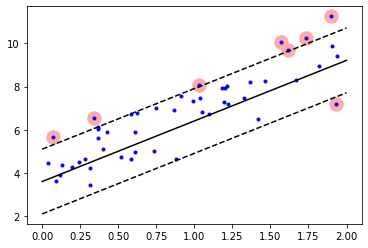

In [173]:
#SVM for regression is simply a reverse of the objective for classification: try to fit as many instances as possible
#between the margins of the SVs for the two classes while limiting margin violations (instances outside of the margins).
#The width of the margin is controlled by hyperparameter epsilon: larger epsilon means larger margin. As with SVM 
#classification, adding more training instances within the margin does not affect the model's predictions: thus, the model
#is said to be epsilon-insensitive.

from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt

def find_support_vectors(svm_reg, X, y, eps):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= eps)
    return np.argwhere(off_margin)

np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

svm_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_lin_reg', LinearSVR(epsilon=1.5))
])

svm_reg.fit(X, y)

sv = find_support_vectors(svm_reg, X, y, svm_reg['svm_lin_reg'].epsilon)

X_range = np.linspace(0, 2, 100).reshape(-1, 1)
y_predict = svm_reg.predict(X_range)
plt.plot(X, y, 'b.')
plt.scatter(X[sv], y[sv], s=180, facecolors='#FFAAAA')
plt.plot(X_range, y_predict, 'k')
plt.plot(X_range, y_predict - svm_reg['svm_lin_reg'].epsilon, 'k--')
plt.plot(X_range, y_predict + svm_reg['svm_lin_reg'].epsilon, 'k--')


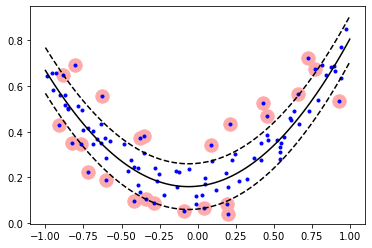

In [202]:
#For nonlinear regression tasks, there is the SVR class (which like SVC supports the kernel trick).

from sklearn.svm import SVR

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

svm_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_poly_reg', SVR(kernel='poly', degree=2, C=100, epsilon=0.1))
])
svm_reg.fit(X, y)

svm_reg.support_ = find_support_vectors(svm_reg, X, y, svm_reg['svm_poly_reg'].epsilon)

X_range = np.linspace(-1, 1, 100).reshape(-1, 1)
y_predict = svm_reg.predict(X_range)
plt.plot(X, y, 'b.')
plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
plt.plot(X_range, y_predict, 'k')
plt.plot(X_range, y_predict-.1, 'k--')
plt.plot(X_range, y_predict+.1, 'k--')

In [200]:
#The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the
#LinearSVC class. The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), 
#while the SVR class gets much too slow when the training set grows large (just like the SVC class).

In [203]:
#SVM Theory:
#The linear SVM classifier predicts the class of a new instance c by computing the decision function h = wTx + b. If the
#result is postiive, the predicted class y_hat = 1 (positive class) and otherwise y_hat = 0 (negative class). The decision
#function represents an n-dimensional hyperplane. The decision boundary is the set of points where h = wTx + b = 0, so it 
#is the intersection of the planes h = 0 and h = wTx + b. Hence the decision boundary is an (n-1) dimensional hyperplane.
#The margin is where the decision function is equal to 1 or -1: they are parallel and at equal distnace to the boundary.
#Training a linear SVM classifier means finding the values of the vector w and the bias b that make the margin as wide as 
#possible while avoiding margin violations (hard margin) or limiting them (soft margin).

#The slope of the decision function is the norm of w: ||w||. Dividing the slope by 2 means the points where the decision 
#function (DF) is equal to +/- 1 will be twice as far from the decision boundary. So, since we want as large a margin as 
#possible, we want to minimize ||w||. For a hard margin, we need the DF > 1 for positive training instances and DF < -1 for
#negative instances. So we constrain the minimization of (1/2)wTw to be subject to t^(i)*(wTx^(i) + b) >= 1 for i = 1 to m
#where t^(i) equals -1 for negative instances and +1 for positive instances (using (1/2)wTw since it is differentiable
#everywhere, unlike ||w|| - better for optimization algorithms).
#The soft margin objective is acheived by introducing a slack variable zeta^(i) >= 0 which measures how much the ith 
#instance is allowed to violate the margin. We have two conflicting objectives: make zeta as small as possible to reduce
#violations, while minimizing (1/2)wTw to increase the margin. The C hyperparameter is used to define the trade-off between
#these two objectives, leaving us with minimize (1/2)wTw + CΣζ^(i) subject to t^(i)*(wTx^(i) + b)≥ 1−ζ^(i) and ζ^(i) ≥ 0 
#for i = 1 to m.

#The hard and soft margin cases are convex quadratic optimization problems with linear constraints - known as QP problems.
#These are conventionally solved using quadratic programming algorithms. However, we can use the kernel trick  by looking
#at a different constrained optimization problem.

#Given a constrained optimization problem, known as the primal problem, it is possible to express it in a different but
#closely related way, called its dual problem. The solution to the dual problem is typically a lower bound to the solution
#of the primal problem, but under the conditions that (1) the objective function is convex, and (2) the inequality
#constraints are continuously differentiable and convex functions, the solutions to the primal and its dual are identical 
#SVM meets these conditions so we can solve either problem and receive the same solution. In the SVM dual we minimize a 
#vector alpha which we can use to find the weight vector w and the bias. The dual is faster to solve than the primal when
#the number of training instances m is smaller than the number of features n, and it makes the kernel trick possible, while
#the primal does not. SEE LEARNING FROM DATA NOTES ON SVM/KERNEL APPROACH

#With regards to online (incremental learning) SVMs, one method for implementing an online linear SVM classifier is to use
#SGD (e.g. using SGDClassifier) to minimize the cost function derived from the primal SVM problem: 
#J(w, b) = (1/2)wTw + C*Σ*max[0, 1 − t^(i)(wTx^(i) + b)], summing from i = 1 to m. The first term of the cost function
#pushes the model to have a small weight vector, leading to a larger margin, while the summation computes the total of
#all margin violations - an instance's margin violation is 0 if it is located out of the margin bounds and on the correct
#side, or else it is proportional to the distance to the correct side of the margin. Minimizing this term makes the 
#violations as small and as few as possible, given the hyperparameter C. 
#N.B. The function max(0, 1 - t) is called the hinge loss function - it is equal to 0 when t >= 1. Its derivative is equal
#to -1 if t < 1 and 0 if t > 1. It is non-differentiable at t=1m but just like Lasso Regression, you can still use GD
#using any subderivative at t=1 (i.e. the gradient can be between -1 and 0, google 'subderivative').
#N.B that GD converges much more slowly than the methods based on QP. It is also possible to implement online kernelized
#SVMs, typically done in C++ and Matlab - for large-scale nonlinear problems, neural networks may be a better option.
